In [1]:
import os
import sys

import shutil
os.chdir("G:\\My Drive\\Ingegneria\\Data Science GD\\Models\\Trading\\Stocks Reinforcement Learning Ensemble") # set cwd

import time
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from stable_baselines3 import SAC
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import TD3
from stable_baselines3 import HER
from stable_baselines3 import DQN

from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv

from env.Environment import EnvSetup
from env.EnvMultipleStockTrain import StockEnvTrain
from env.EnvMultipleStockValidation import StockEnvValidation
from env.EnvMultipleStockTrade import StockEnvTrade

import talib

import optuna

from inputs import config_

import yfinance as yf


C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calc_turbulence(df):

    # pivot the original df to get the correct format (one column per tickers) for the turbulence calculation
    df_pivot = df.pivot(index='Date', columns='Ticker', values='Adj Close')

    # calculate the daily returs for each ticker
    returns = df_pivot.pct_change()

    # Calculate the mean returns and covariance matrix
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Calculate the turbulence index for each day
    turbulence_index = pd.Series(index=returns.index)
    for i in range(len(returns)):
        diff = returns.iloc[i] - mean_returns
        turbulence_index[i] = diff.dot(np.linalg.inv(cov_matrix)).dot(diff.T) #  to weight each element of the diff vector by how much it contributes to the overall variance of the asset returns.

    # Normalize the turbulence index
    turbulence_index = turbulence_index / len(df_pivot.columns)
    df_turb = pd.DataFrame(turbulence_index)
    
    df = df.merge(df_turb, on='Date')
    df = df.rename(columns={0: 'Turbulence'})

    return df

In [3]:
# tickers = config_.DOW_30_TICKER

# df = pd.DataFrame()
    
# for ticker in tickers:
#     ticker_df = yf.download(ticker, start= "2000-01-01", end= "2024-01-01") 
#     ticker_df.sort_values('Date', inplace=True)
#     ticker_df['MACD'], ticker_df['MACD_signal'], ticker_df['MACD_hist'] = talib.MACD(ticker_df['Adj Close'])
#     ticker_df['RSI21'] = talib.RSI(ticker_df['Adj Close'], timeperiod=21)
#     ticker_df['CCI21'] = talib.CCI(ticker_df['High'], ticker_df['Low'], ticker_df['Adj Close'], timeperiod=21)
#     ticker_df['ATR21'] = talib.ATR(ticker_df['High'], ticker_df['Low'], ticker_df['Adj Close'], timeperiod=21)
#     ticker_df['+DMI21'] = talib.PLUS_DI(ticker_df['High'],ticker_df['Low'],ticker_df['Adj Close'],timeperiod=21)
#     ticker_df['-DMI21'] = talib.MINUS_DI(ticker_df['High'],ticker_df['Low'],ticker_df['Adj Close'],timeperiod=21)
#     ticker_df['ADX21'] = talib.ADX(ticker_df['High'],ticker_df['Low'],ticker_df['Adj Close'],timeperiod=21)
#     ticker_df['Ticker'] = ticker 
#     df = pd.concat([df, pd.DataFrame(ticker_df)])

# df.to_csv('inputs/df.csv')

In [4]:
df = pd.read_csv('inputs/df.csv')
df = calc_turbulence(df)
df = df.dropna()
df.reset_index(inplace=True, drop=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_signal,MACD_hist,RSI21,CCI21,ATR21,+DMI21,-DMI21,ADX21,Ticker,Turbulence
0,2000-03-02,39.972034,40.099682,38.622612,38.969086,28.033796,8707643,-1.293481,-0.903550,-0.389931,38.985916,-79.601865,13.084495,1.622394,4.058675,25.259126,AXP,2.894102
1,2000-03-02,65.312500,67.875000,63.000000,65.312500,47.318504,12075000,0.252899,0.467997,-0.215098,49.093379,-59.373498,20.665390,4.504472,5.366076,5.934448,AMGN,2.894102
2,2000-03-02,1.133929,1.142299,1.077567,1.089286,0.923366,311259200,0.030402,0.025507,0.004895,54.648514,185.295293,0.185088,8.904059,6.538580,7.513739,AAPL,2.894102
3,2000-03-02,36.312500,37.187500,35.375000,35.937500,23.276478,4058200,-1.093186,-0.987795,-0.105392,42.392385,-87.275586,15.007689,2.054148,2.558177,13.337771,BA,2.894102
4,2000-03-02,17.437500,17.500000,17.093750,17.218750,9.199947,3956000,-0.805224,-0.838973,0.033749,31.265131,-130.439186,10.154435,1.229186,2.952335,32.993898,CAT,2.894102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161887,2023-12-29,525.979980,528.239990,523.919983,526.469971,526.469971,2080100,-4.245183,-2.773944,-1.471239,46.875479,-53.075642,7.756212,16.717518,22.727781,19.353647,UNH,0.095340
161888,2023-12-29,37.380001,37.759998,37.320000,37.700001,37.074799,16205200,0.248788,0.379503,-0.130715,58.130337,-29.525042,0.958489,13.990541,10.249013,25.282952,VZ,0.095340
161889,2023-12-29,26.440001,26.629999,25.750000,26.110001,26.110001,10853300,1.384881,1.233025,0.151857,65.720441,71.969465,0.863913,30.914270,13.810820,29.463601,WBA,0.095340
161890,2023-12-29,157.529999,158.080002,157.160004,157.649994,157.649994,7314200,-0.028408,-0.821300,0.792892,52.068674,137.706863,2.131293,23.471639,21.698666,14.348200,WMT,0.095340


In [5]:
corr = df.drop(['Date', 'Ticker'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_signal,MACD_hist,RSI21,CCI21,ATR21,+DMI21,-DMI21,ADX21,Turbulence
Open,1.000000,0.999894,0.999880,0.999785,0.988357,-0.180593,0.193583,0.203480,0.011287,0.072701,0.034190,0.300553,0.487937,0.437207,0.007695,-0.110582
High,0.999894,1.000000,0.999827,0.999891,0.988532,-0.180363,0.191744,0.201347,0.011778,0.072735,0.035021,0.300425,0.489605,0.439033,0.008215,-0.107215
Low,0.999880,0.999827,1.000000,0.999889,0.988351,-0.180893,0.196544,0.205653,0.014272,0.076640,0.037889,0.300678,0.487018,0.434367,0.007336,-0.113763
Close,0.999785,0.999891,0.999889,1.000000,0.988536,-0.180641,0.194539,0.203488,0.014327,0.076521,0.037973,0.300530,0.488515,0.436505,0.007883,-0.110176
Adj Close,0.988357,0.988532,0.988351,0.988536,1.000000,-0.151795,0.192786,0.201434,0.014858,0.071236,0.035274,0.153907,0.565246,0.511568,0.007744,-0.111540
Volume,-0.180593,-0.180363,-0.180893,-0.180641,-0.151795,1.000000,-0.021307,-0.021249,-0.004679,0.004862,-0.003062,-0.223404,0.045221,0.052682,0.095706,0.050510
MACD,0.193583,0.191744,0.196544,0.194539,0.192786,-0.021307,1.000000,0.950237,0.360389,0.587740,0.396716,0.006029,0.213788,-0.217844,0.050567,-0.151810
MACD_signal,0.203480,0.201347,0.205653,0.203488,0.201434,-0.021249,0.950237,1.000000,0.051860,0.519976,0.262098,0.012208,0.182050,-0.199596,0.061160,-0.146085
MACD_hist,0.011287,0.011778,0.014272,0.014327,0.014858,-0.004679,0.360389,0.051860,1.000000,0.327142,0.486940,-0.017228,0.140222,-0.100688,-0.021031,-0.049232
RSI21,0.072701,0.072735,0.076640,0.076521,0.071236,0.004862,0.587740,0.519976,0.327142,1.000000,0.799950,-0.012843,0.117729,-0.238274,0.124781,-0.157293


In [6]:
df = df.drop(['Open','High','Low','Close','MACD_signal'], axis=1)

df = df[df.Ticker.isin(config_.DOW_sel_TICKER)]

df

,Date,Adj Close,Volume,MACD,MACD_hist,RSI21,CCI21,ATR21,+DMI21,-DMI21,ADX21,Ticker,Turbulence
2,2000-03-02,0.923366,311259200,0.030402,0.004895,54.648514,185.295293,0.185088,8.904059,6.538580,7.513739,AAPL,2.894102
3,2000-03-02,23.276478,4058200,-1.093186,-0.105392,42.392385,-87.275586,15.007689,2.054148,2.558177,13.337771,BA,2.894102
11,2000-03-02,33.326828,36469800,1.407970,-0.003581,63.005642,144.403158,23.445025,2.983329,1.695648,35.449994,INTC,2.894102
13,2000-03-02,12.807508,11358600,-0.692297,-0.047209,41.385618,-67.544201,13.849772,1.292476,1.706274,16.570925,KO,2.894102
18,2000-03-02,28.944557,106932600,-1.275920,-0.029269,38.402806,-73.891219,20.064617,1.455838,2.813625,32.943463,MSFT,2.894102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161876,2023-12-29,50.250000,29266500,2.323294,0.393488,70.657071,131.160303,1.274397,39.003296,11.804960,36.828063,INTC,0.095340
161878,2023-12-29,58.930000,9241600,0.324693,-0.097240,57.469803,37.821509,0.752743,21.037559,19.236289,12.019576,KO,0.095340
161883,2023-12-29,376.040009,18723000,2.688171,-0.502421,58.435836,96.528979,5.629226,25.185862,15.037656,25.397692,MSFT,0.095340
161884,2023-12-29,108.570000,7660900,0.089720,-1.908133,45.833113,-98.250580,2.597086,26.608330,30.909741,26.146247,NKE,0.095340


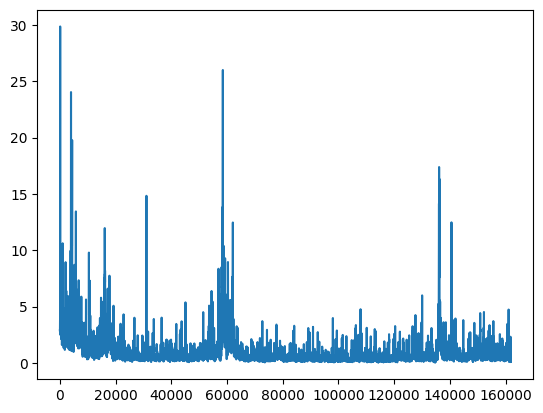

Series([], Name: Date, dtype: object) Twin Towers
Series([], Name: Date, dtype: object) Market Crush
Series([], Name: Date, dtype: object) Covid


In [7]:
plt.plot(df.Turbulence)
plt.show()
print(df[df.index==10000].Date, 'Twin Towers')
print(df[df.index==60000].Date, 'Market Crush')
print(df[df.index==135000].Date, 'Covid')

In [8]:
# class LoggingCallback:
#     def __init__(self,threshold,trial_number,patience):
#         '''
#         threshold:int tolerance for increase in sharpe ratio
#         trial_number: int Prune after minimum number of trials
#         patience: int patience for the threshold
#         '''
#         self.threshold = threshold
#         self.trial_number  = trial_number
#         self.patience = patience
#         self.cb_list = [] #Trials list for which threshold is reached
#     def __call__(self,study:optuna.study, frozen_trial:optuna.Trial):
#         #Setting the best value in the current trial
#         study.set_user_attr("previous_best_value", study.best_value)

#         #Checking if the minimum number of trials have pass
#         if frozen_trial.number >self.trial_number:
#             previous_best_value = study.user_attrs.get("previous_best_value",None)
#             #Checking if the previous and current objective values have the same sign
#             if previous_best_value * study.best_value >=0:
#                 #Checking for the threshold condition
#                 if abs(previous_best_value-study.best_value) < self.threshold: 
#                     self.cb_list.append(frozen_trial.number)
#                     #If threshold is achieved for the patience amount of time
#                     if len(self.cb_list)>self.patience:
#                         print('The study stops now...')
#                         print('With number',frozen_trial.number ,'and value ',frozen_trial.value)
#                         print('The previous and current best values are {} and {} respectively'
#                               .format(previous_best_value, study.best_value))
#                         study.stop()
                        




def sample_A2C_params(trial:optuna.Trial):
    # Learning rate for the model training
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1, log=True)
    # Discount factor
    gamma = trial.suggest_float("gamma", 0.8, 0.9999)
    # Factor for trade-off of bias vs variance for Generalized Advantage Estimator
    gae_lambda = trial.suggest_float("gae_lambda", 0.8, 1.0)
    # The number of steps to run for each environment per update
    n_steps = trial.suggest_int("n_steps", 5, 2000)
    # Entropy coefficient for the loss calculation
    ent_coef = trial.suggest_float("ent_coef", 0.0, 0.5)
    # Value function loss coefficient
    vf_coef = trial.suggest_float("vf_coef", 0.0, 0.5)

    return {"learning_rate": learning_rate,
            "gamma": gamma,
            "gae_lambda": gae_lambda,
            "n_steps": n_steps,
            "ent_coef": ent_coef,
            "vf_coef": vf_coef}





''' Models and Validation Functions'''

In [9]:
'''
When you call model.learn(total_timesteps=timesteps), the DRL model starts the learning process, which involves interacting with the environment. During this process, the model selects actions based on its current policy and applies these actions to the environment. The application of an action to the environment is done through the step() method.
So, even though you’re not explicitly calling env_train.step(), it’s being called internally by the model.learn() method. This is how the model is able to interact with the environment and learn from it.
'''

def train_A2C(env_train, model_name, timesteps, working_path, hyperparameters=config_.A2C_PARAMS):
    start = time.time()
    model = A2C('MlpPolicy', env_train, **hyperparameters)
    model.learn(total_timesteps=timesteps) 
    end = time.time()
    model.save(working_path+'/'+model_name)
    print(' - Training time (A2C): ', (end - start) / 60, ' minutes')    
    return model

def train_PPO(env_train, model_name, timesteps, working_path, hyperparameters=config_.PPO_PARAMS):
    start = time.time()
    model = PPO('MlpPolicy', env_train, **hyperparameters)  
    model.learn(total_timesteps=timesteps)
    end = time.time()
    model.save(working_path+'/'+model_name)
    print(' - Training time (PPO): ', (end - start) / 60, ' minutes')
    return model

def train_DDPG(env_train, model_name, timesteps, working_path, hyperparameters=config_.DDPG_PARAMS):
    # add the noise objects for DDPG    # param_noise = None
    n_actions = env_train.action_space.shape[-1]
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions)) # This is a type of noise that is commonly used in DDPG algorithms to promote exploration.
    start = time.time()
    model = DDPG('MlpPolicy', env_train, **hyperparameters)
    model.learn(total_timesteps=timesteps)
    end = time.time()
    model.save(working_path+'/'+model_name)
    print(' - Training time (DDPG): ', (end-start)/60,' minutes')
    return model

In [10]:
        
def DRL_predict(model, data, env, init_obs, working_path, model_name, stocks_dim):
    total_reward = 0
    # In each iteration of the loop, the model makes a prediction based on the current observation state (curr_obs). This prediction are the actions that the model decides to take given the current state.
    curr_obs = init_obs
    for i in range(len(data.index.unique())):
        print ('\n |||||||||||||||||||||||||', i+1, 'over', len(data.index.unique()), 
               '|||||||||||||| Date:', data.iloc[i*stocks_dim].Date,'||||||||||||||||||||||||')
        print('\ncurr_obs\n',curr_obs) ####################################3
        actions, _states = model.predict(curr_obs)
        curr_obs, rewards, dones, info = env.step(actions=actions)
        total_reward += rewards
        if i == (len(data.index.unique())-1): 
            last_state = curr_obs[0]
            print('\ncurr_obs_last_s\n',last_state)
    df_last_state = pd.DataFrame(last_state)
    df_last_state.to_csv(working_path+'/last_state_{}.csv'.format(model_name), index=False)     
    print('\npredicted validation actions (last day)\n',actions)
    return total_reward
                
        
def get_validation_sharpe(model_name, working_path): # function to generalize for all environments, or to delete and simplify the code
    df_total_value = pd.read_csv(working_path+'/account_value_validation_{}.csv'.format(model_name), index_col=0)
    df_total_value.columns = ['account_value_validation'] # account_value_train before
    df_total_value['daily_return'] = df_total_value.pct_change(1)
    sharpe = np.sqrt(252) * df_total_value['daily_return'].mean() / df_total_value['daily_return'].std() 
    return df_total_value, sharpe


def plot_datasets(df, start_index, train_init_quarters, valid_quarters, trade_quarters, initial_amount):
    # Define the colors for the different data sets
    colors = {'train': 'blue', 'valid': 'green', 'trade': 'red'}
    revenues = {}

    # Calculate the indices for the different data sets
    train_end_index = start_index + train_init_quarters * 63
    valid_end_index = train_end_index + valid_quarters * 63
    trade_end_index = valid_end_index + trade_quarters * 63

    # Get the unique stock symbols
    tickers = df['Ticker'].unique()
    init_amount_stock = initial_amount/df['Ticker'].nunique()

    # Create a separate plot for each stock
    for ticker in tickers:
        # Filter the data for the current stock
        stock_data = df[df['Ticker'] == ticker]

        # Get the stock prices at the beginning and end of the trading period
        start_trade_price = stock_data['Adj Close'][valid_end_index]
        end_trade_price = stock_data['Adj Close'][trade_end_index]
        # Calculate the revenue
        fin_amount_stock = init_amount_stock/start_trade_price*end_trade_price
        
        revenues[ticker] = fin_amount_stock
        
        # Plot the data
        plt.figure(figsize=(14, 7))
        plt.plot(stock_data.index[start_index:train_end_index], 
                 stock_data['Adj Close'][start_index:train_end_index], 
                 color=colors['train'], label='Train')
        plt.plot(stock_data.index[train_end_index:valid_end_index], 
                 stock_data['Adj Close'][train_end_index:valid_end_index], 
                 color=colors['valid'], label='Valid')
        plt.plot(stock_data.index[valid_end_index:trade_end_index], 
                 stock_data['Adj Close'][valid_end_index:trade_end_index], 
                 color=colors['trade'], label='Trade')

        # Add labels and title
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.title(f'Stock Closing Prices for {ticker}')
        plt.legend()
        
        # Print the initial and final revenue on the plot
        plt.text(valid_end_index, start_trade_price, f'Initial Amount: {init_amount_stock}')
        plt.text(trade_end_index, end_trade_price, f'Final Amount: {fin_amount_stock}')

        # Show the plot
        plt.show()
    
    steady_revenue = sum(revenues.values())
    return steady_revenue

''' ENSEMBLE train & validation'''

In [11]:
'''
The run_ensemble_strategy function is designed to train and validate multiple reinforcement learning models (A2C, PPO, DDPG), through a TimeSeriesSplit cross validation algorithm, select the best model based on the Sharpe ratio, retrain it on the whole 'train+validation' dataset, and then use that model to make predictions on the 'trade' dataset.
'''

def run_strategy(df, date_start="0000-00-00", train_init_quarters= 4, valid_quarters=4, trade_quarters=4, 
                          rebalance_quarters=1, max_rebalances_input=None):
    
    start = time.time()
        
    df.index = df.Date.factorize()[0] # to create a index with a unique value for each Date
    
    all_dates_sorted = np.sort(df.Date.unique())       
    start_index = np.searchsorted(all_dates_sorted, max(date_start,all_dates_sorted[1])) # starting at least from the second position
    
    steady_revenue = plot_datasets(df, start_index,train_init_quarters, valid_quarters, trade_quarters, config_.initial_amount)
    
    dates_sorted = all_dates_sorted[start_index:]
    date_before_start = all_dates_sorted[start_index - 1]
    
    all_quarters = len(dates_sorted)//63 # 63 = trade days per quarter
    max_rebalances_allowed = all_quarters-train_init_quarters-valid_quarters-trade_quarters
    
    if max_rebalances_input == None: # no user input
        rebalances = max_rebalances_allowed
    else:
        rebalances = min(max_rebalances_input, max_rebalances_allowed)
    
    if rebalances < 1:
        print('Enter valid date range')
        sys.exit()
    
    working_folder_name = 'FROM('+str(date_start)+ \
    ')_QUARTERS('+str(train_init_quarters)+'-'+str(valid_quarters)+'-'+str(trade_quarters)+ \
    ')_REBALANCES('+str(rebalances)+'-'+str(rebalance_quarters)+ \
    ')_TS('+str(config_.A2C_TS)+'-'+str(config_.DDPG_TS)+'-'+str(config_.PPO_TS)+')'
    
    working_path = 'working/'+working_folder_name
    # Check if the directory exists
    if os.path.exists(working_path):
        # Delete directory and all files in the directory
        shutil.rmtree(working_path)
    # Create the directory
    os.makedirs(working_path)
    
    stocks_dim = df.Ticker.nunique()
    state_space = 1 + (len(config_.TECHNICAL_INDICATORS_LIST) + 2) * stocks_dim # stocks_dimension * (Close Price, Shares owned, MACD, RSI, CCI, ADX) + Balance
    
    # Initialize variables: Lists are created to store the last state of the ensemble model and the Sharpe ratios of the different models.
    last_state_ensemble = []
    ppo_sharpe_list = []
    ddpg_sharpe_list = []
    a2c_sharpe_list = []
    
    #implementing TimeSeriesSplit, with increasing train quarter window and fixed validation and trade windows
    for i in range(0, rebalances*rebalance_quarters, rebalance_quarters):
        train_end_ind = (start_index + train_init_quarters*63 + i*63) * stocks_dim
        validation_end_ind = (start_index + train_init_quarters*63 + valid_quarters*63 + i*63) * stocks_dim
    
        train_data = df.iloc[start_index*stocks_dim:train_end_ind]
        validation_data = df.iloc[train_end_ind:validation_end_ind]
        
        retrain_data = df.iloc[start_index*stocks_dim:validation_end_ind]
        trade_data = df.iloc[validation_end_ind : validation_end_ind+trade_quarters*63*stocks_dim]
        
        initial_close_train = df[df.Date == date_before_start]['Adj Close'].to_list()
        # print('initial_close_train',initial_close_train, date_before_start)
        initial_close_valid = train_data['Adj Close'].iloc[-1*stocks_dim:].tolist()
        # print('initial_close_valid',initial_close_valid, max(train_data.Date))
        initial_close_trade = retrain_data['Adj Close'].iloc[-1*stocks_dim:].tolist()
        # print('initial_close_trade',initial_close_trade, max(retrain_data.Date))
        
        insample_turbulence_threshold = np.quantile(df.iloc[start_index:train_end_ind].Turbulence.unique(), .90) # 90% quantile 
        historical_turbulence_mean = np.mean(df.iloc[start_index:train_end_ind].Turbulence.unique())
        # calculates the turbulence threshold for the current iteration based on historical turbulence
        if historical_turbulence_mean > insample_turbulence_threshold:
            # The turbulence threshold is a measure of market uncertainty or risk. When market is more volatile, risk is higher. By setting a lower turbulence threshold, the model becomes more conservative: more likely to trigger the turbulence condition, signaling high risk.
            # if the mean of the historical data is greater than the 90% quantile of insample turbulence data, the current market is volatile, therefore we set the 90% quantile of insample turbulence data as the turbulence threshold (maximum allowed threshold)
            turbulence_threshold = insample_turbulence_threshold
        else:
            #On the other hand, when the market is less volatile, the risk is lower. By setting a higher turbulence threshold during these times, the model allows for more aggressive strategies because it’s less likely to trigger the turbulence condition.
            # if the mean of the historical data is less than the 90% quantile of insample turbulence data, then we set a 99% risk threshold
            turbulence_threshold = np.quantile(df.Turbulence.unique(), .99) 
        

        print('cycle')
        print(i)
        print('train indexes')
        print(start_index*stocks_dim, train_end_ind)
        print('validation indexes')
        print(train_end_ind, validation_end_ind)
        print('lenght of the datasets:')
        print(len(train_data), len(validation_data))
        print('min and max train date')
        print(min(train_data.Date), max(train_data.Date))
        print('min and max validation date')
        print(min(validation_data.Date), max(validation_data.Date))
        print('train dataset.shape')
        print(train_data.shape)
        print('validation dataset.shape')
        print(validation_data.shape) 
        print(" - insample_turbulence_threshold: - ")
        print(insample_turbulence_threshold) 
        print(" - historical_turbulence_mean: - ")
        print(historical_turbulence_mean)
        print(" - Turbulence_threshold: - ")
        print(turbulence_threshold)

            
        env_setup = EnvSetup(stocks_dim = stocks_dim,
                             state_space = state_space,
                             hmax = 100,
                             initial_amount = 1000000,
                             transaction_cost_pct = 0.001,
                             working_path = working_path)


        if config_.ensemble_training == True:  ########################################################################################3

            
            print('-------------------------------------------------------------------------------------------')
            print(" - Model train from: ", min(train_data.Date), "to ", max(train_data.Date))
            print(" - Model validation from: ", min(validation_data.Date), "to ", max(validation_data.Date))
            print('-------------------------------------------------------------------------------------------')
                   
            #DDPG

            model_name_ddpg = 'DDPG_cycle{:02d}_timesteps{}'.format(int(i/rebalance_quarters+1),config_.DDPG_TS)

            env_train, _ = env_setup.create_environment(data = train_data, env_class = StockEnvTrain, 
                                                        initial_close = initial_close_train, model_name=model_name_ddpg)

            env_val, init_obs_val = env_setup.create_environment(data = validation_data, env_class = StockEnvValidation,
                                        initial_close = initial_close_valid, model_name=model_name_ddpg, turbulence_threshold=turbulence_threshold)

            print(" - DDPG Training in progress...")
            model_ddpg = train_DDPG(env_train, model_name=model_name_ddpg, timesteps=config_.DDPG_TS, working_path=working_path) 
            print(" - DDPG Training completed!")
            print(" - DDPG Validation in progress...")
            val_reward_ddpg = DRL_predict(model=model_ddpg, data=validation_data, env=env_val, init_obs=init_obs_val,
                                         working_path=working_path, model_name=model_name_ddpg, stocks_dim=stocks_dim)
            print(" - DDPG Validation completed!") 
            print('DDPG Validation Reward:', val_reward_ddpg)
            df_total_value_ddpg, sharpe_ddpg = get_validation_sharpe(model_name_ddpg, working_path)
            print('df_total_value_ddpg')
            print(df_total_value_ddpg)
            print(" - DDPG Sharpe Ratio: ", sharpe_ddpg)          


            # A2C

            model_name_a2c = 'A2C_cycle{:02d}_timesteps{}'.format(int(i/rebalance_quarters+1),config_.A2C_TS)

            env_train, _ = env_setup.create_environment(data = train_data, env_class = StockEnvTrain, 
                                                        initial_close = initial_close_train, model_name=model_name_a2c)

            env_val, init_obs_val = env_setup.create_environment(data = validation_data, env_class = StockEnvValidation,  
                                    initial_close = initial_close_valid, model_name=model_name_a2c, turbulence_threshold=turbulence_threshold)

            print(" - A2C Training in progress...")
            model_a2c = train_A2C(env_train, model_name=model_name_a2c, timesteps=config_.A2C_TS, working_path=working_path) 
            print(" - A2C Training completed!")
            print(" - A2C Validation in progress...")
            val_reward_a2c = DRL_predict(model=model_a2c, data=validation_data, env=env_val, init_obs=init_obs_val,
                                         working_path=working_path, model_name=model_name_a2c, stocks_dim=stocks_dim)
            print(" - A2C Validation completed!")        
            print('A2C Validation Reward:', val_reward_a2c)
            df_total_value_a2c, sharpe_a2c = get_validation_sharpe(model_name_a2c, working_path)
            print('df_total_value_a2c')
            print(df_total_value_a2c)
            print(" - A2C Sharpe Ratio: ", sharpe_a2c)                  


            # PPO

            model_name_ppo = 'PPO_cycle{:02d}_timesteps{}'.format(int(i/rebalance_quarters+1),config_.PPO_TS)

            env_train, _ = env_setup.create_environment(data = train_data, env_class = StockEnvTrain, 
                                                        initial_close = initial_close_train, model_name=model_name_ppo)

            env_val, init_obs_val = env_setup.create_environment(data = validation_data, env_class = StockEnvValidation,
                                        initial_close = initial_close_valid, model_name=model_name_ppo, turbulence_threshold=turbulence_threshold)

            print(" - PPO Training in progress...")
            model_ppo = train_PPO(env_train, model_name=model_name_ppo, timesteps=config_.PPO_TS, working_path=working_path) 
            print(" - PPO Training completed!")
            print(" - PPO Validation in progress...")
            val_reward_ppo = DRL_predict(model=model_ppo, validation_data=validation_data, env_val=env_val, init_obs_val=init_obs_val,
                                         working_path=working_path, model_name=model_name_ppo, stocks_dim=stocks_dim)
            print(" - PPO Validation completed!") 
            print('PPO Validation Reward:', val_reward_ppo)
            df_total_value_ppo, sharpe_ppo = get_validation_sharpe(model_name_ppo, working_path)
            print('df_total_value_ppo')
            print(df_total_value_ppo)
            print(" - PPO Sharpe Ratio: ", sharpe_ppo)

            ppo_sharpe_list.append(sharpe_ppo)
            a2c_sharpe_list.append(sharpe_a2c)
            ddpg_sharpe_list.append(sharpe_ddpg)      

            # TRADE using the model with best sharpe ratio average

            sharpe_ppo_mean = np.nanmean(ppo_sharpe_list)
            sharpe_a2c_mean = np.nanmean(a2c_sharpe_list)
            sharpe_ddpg_mean = np.nanmean(ddpg_sharpe_list)

            print('\nppo_sharpe_list',ppo_sharpe_list)
            print('sharpe_ppo_mean',sharpe_ppo_mean)
            print('a2c_sharpe_list',a2c_sharpe_list)
            print('sharpe_a2c_mean',sharpe_a2c_mean)
            print('ddpg_sharpe_list',ddpg_sharpe_list)
            print('sharpe_ddpg_mean',sharpe_ddpg_mean)

            print('-------------------------------------------------------------------------------------------')
            print(" - Model retrained from: ", min(retrain_data.Date), "to ", max(retrain_data.Date))  
            print(" - Model trade from: ", min(trade_data.Date), "to ", max(trade_data.Date))  
            print('-------------------------------------------------------------------------------------------')

            print('Re-training in progress...')

            if (sharpe_ppo_mean > sharpe_a2c_mean) & (sharpe_ppo_mean > sharpe_ddpg_mean):
                model_name = 'PPO_selected_timesteps{}'.format(config_.PPO_TS)
                env_retrain, _ = env_setup.create_environment(data = retrain_data, env_class = StockEnvTrain, 
                                                              initial_close = initial_close_train, model_name=model_name)
                model_selected = train_PPO(env_retrain, model_name=model_name, timesteps=config_.PPO_TS, working_path=working_path)
            elif (sharpe_a2c_mean > sharpe_ppo_mean) & (sharpe_a2c_mean > sharpe_ddpg_mean):
                model_name = 'A2C_selected_timesteps{}'.format(config_.A2C_TS)
                env_retrain, _ = env_setup.create_environment(data = retrain_data, env_class = StockEnvTrain, 
                                                              initial_close = initial_close_train, model_name=model_name)
                model_selected = train_A2C(env_retrain, model_name=model_name, timesteps=config_.A2C_TS, working_path=working_path)
            else:
                model_name = 'DDPG_selected_timesteps{}'.format(config_.DDPG_TS)
                env_retrain, _ = env_setup.create_environment(data = retrain_data, env_class = StockEnvTrain, 
                                                              initial_close = initial_close_train, model_name=model_name)
                model_selected = train_DDPG(env_retrain,model_name=model_name, timesteps=config_.DDPG_TS, working_path=working_path)
                
            print('SELECTED MODEL:', model_selected)
            print(model_selected," re-training completed!")

    else: ###############################################################################################################################3
        
        model_name = 'A2C_selected_timesteps{}'.format(config_.A2C_TS)
           
        def objective(trial):
            env_train_hypopt, _ = env_setup.create_environment(data = retrain_data, env_class = StockEnvTrain, 
                                                          initial_close = initial_close_train, model_name=model_name)
            hyperparameters = sample_A2C_params(trial)
            model = A2C('MlpPolicy', env_train_hypopt, **hyperparameters) # , verbose=0
            print("\n - Optuna train from: ", min(retrain_data.Date), "to ", max(retrain_data.Date))
            model.learn(total_timesteps=config_.A2C_TS)
            return env_train_hypopt.envs[0].sharpe
        
        sampler = optuna.samplers.TPESampler(seed=42)
        
        study = optuna.create_study(study_name="A2C_study",direction='maximize', sampler = sampler, pruner=optuna.pruners.HyperbandPruner())
        
        study.optimize(objective, n_trials=config_.OPTUNA_TRIALS)
        
        optim_hyperparams = study.best_params
        
        print('\noptim_hyperparams', optim_hyperparams)
        
        # logging_callback = LoggingCallback(threshold=1e-5,patience=30,trial_number=5)
        
        env_retrain, _ = env_setup.create_environment(data = retrain_data, env_class = StockEnvTrain, 
                                                      initial_close = initial_close_train, model_name=model_name)
        
        print("\n - Model retrain from: ", min(retrain_data.Date), "to ", max(retrain_data.Date))
        #add the new optimal hyperparameters in the last training
        model_selected = train_A2C(env_retrain, model_name=model_name, timesteps=config_.A2C_TS, working_path=working_path,
                                  hyperparameters=optim_hyperparams)
            
        print('\nSELECTED MODEL:', model_selected)
        print(model_selected," re-training completed!")
        
        print("\n - Model trade from: ", min(trade_data.Date), "to ", max(trade_data.Date))
        
        
    # recalculate turbulence threshold on the full retraining dataset
    insample_turbulence_threshold = np.quantile(df.iloc[start_index:validation_end_ind].Turbulence.unique(), .90) # 90% quantile 
    historical_turbulence_mean = np.mean(df.iloc[start_index:validation_end_ind].Turbulence.unique())
    if historical_turbulence_mean > insample_turbulence_threshold:
        turbulence_threshold = insample_turbulence_threshold
    else:
        turbulence_threshold = np.quantile(df.Turbulence.unique(), .95) 

    print('trade indexes')
    print(validation_end_ind, validation_end_ind+trade_quarters*63*stocks_dim)
    print('lenght of the dataset:')
    print(len(trade_data))
    print('min and max trade date')
    print(min(trade_data.Date), max(trade_data.Date))
    print('trade dataset.shape')
    print(trade_data.shape)
    print(" - insample_turbulence_threshold: - ")
    print(insample_turbulence_threshold) 
    print(" - historical_turbulence_mean: - ")
    print(historical_turbulence_mean)
    print(" - Turbulence_threshold: - ")
    print(turbulence_threshold)          

    env_trade, init_obs_trade = env_setup.create_environment(data = trade_data, env_class = StockEnvTrade, initial_close = initial_close_trade,
                                                             model_name=model_name, turbulence_threshold=turbulence_threshold)   
    print('\nenv_trade\n',env_trade) ####################################3
    
    DRL_predict(model=model_selected, data=trade_data, env=env_trade, init_obs=init_obs_trade, 
                working_path=working_path, model_name=model_name, stocks_dim=stocks_dim)
    
    end = time.time()
    
    print("Whole Strategy took: ", (end - start) / 60, " minutes")
    print ('Steady Total Asset Revenue:', steady_revenue)
           

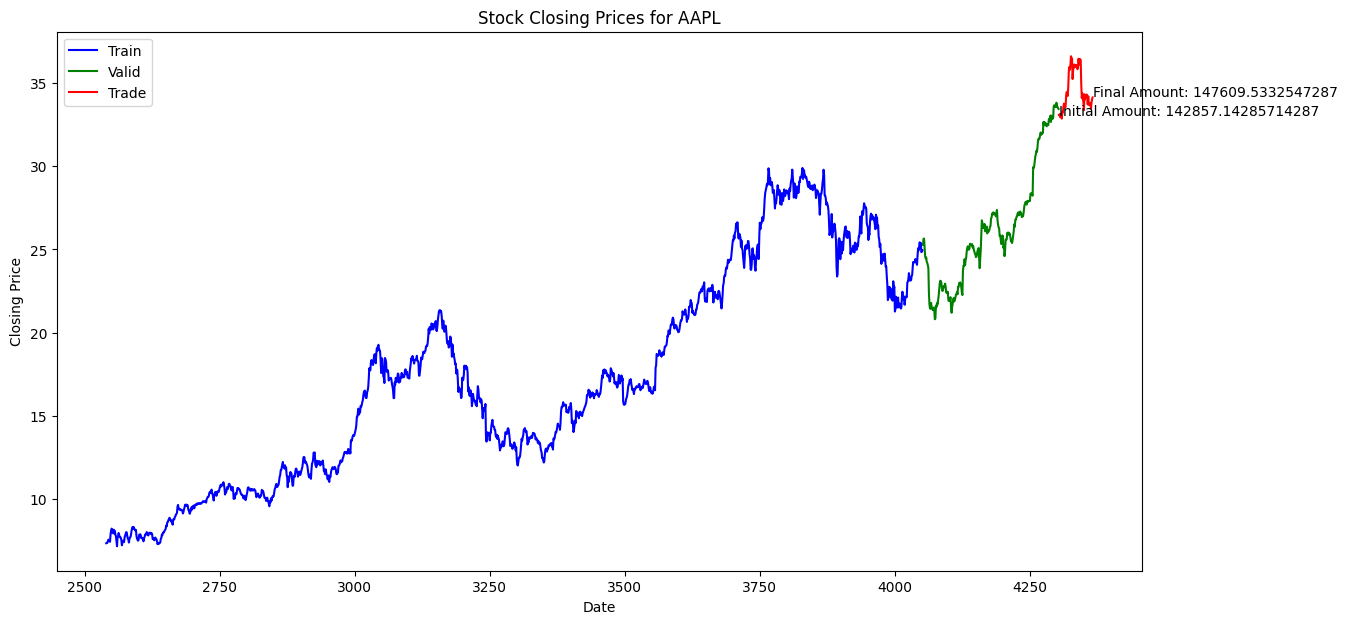

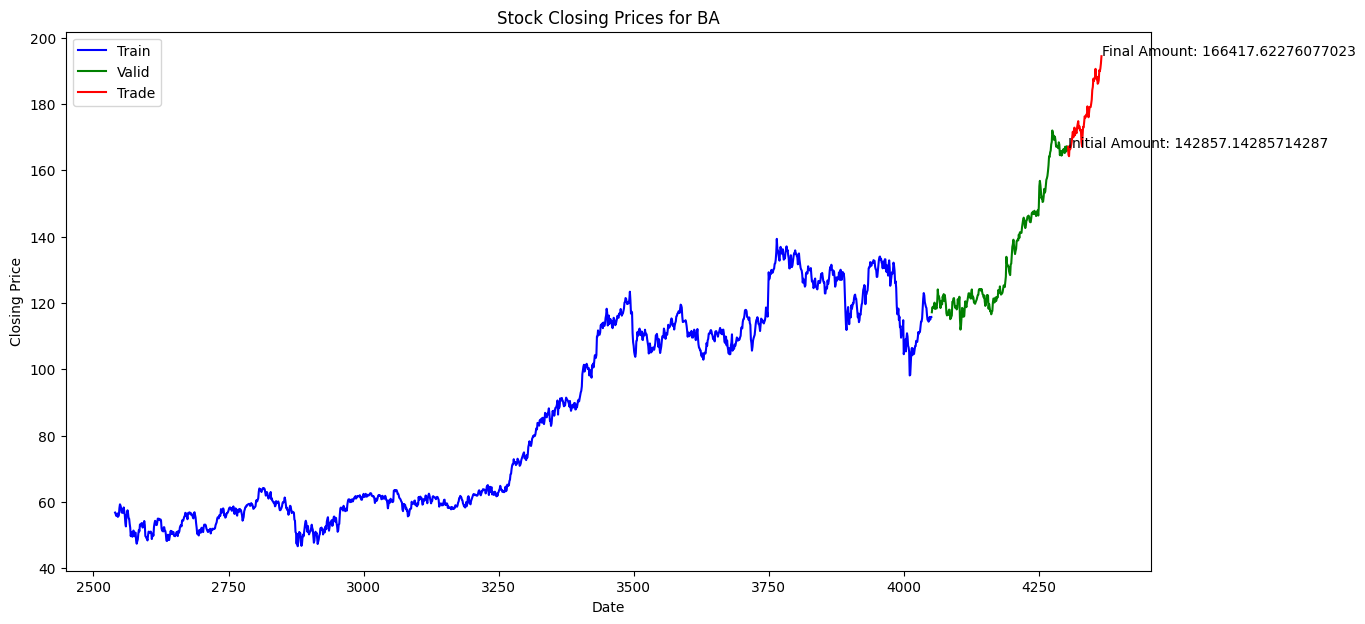

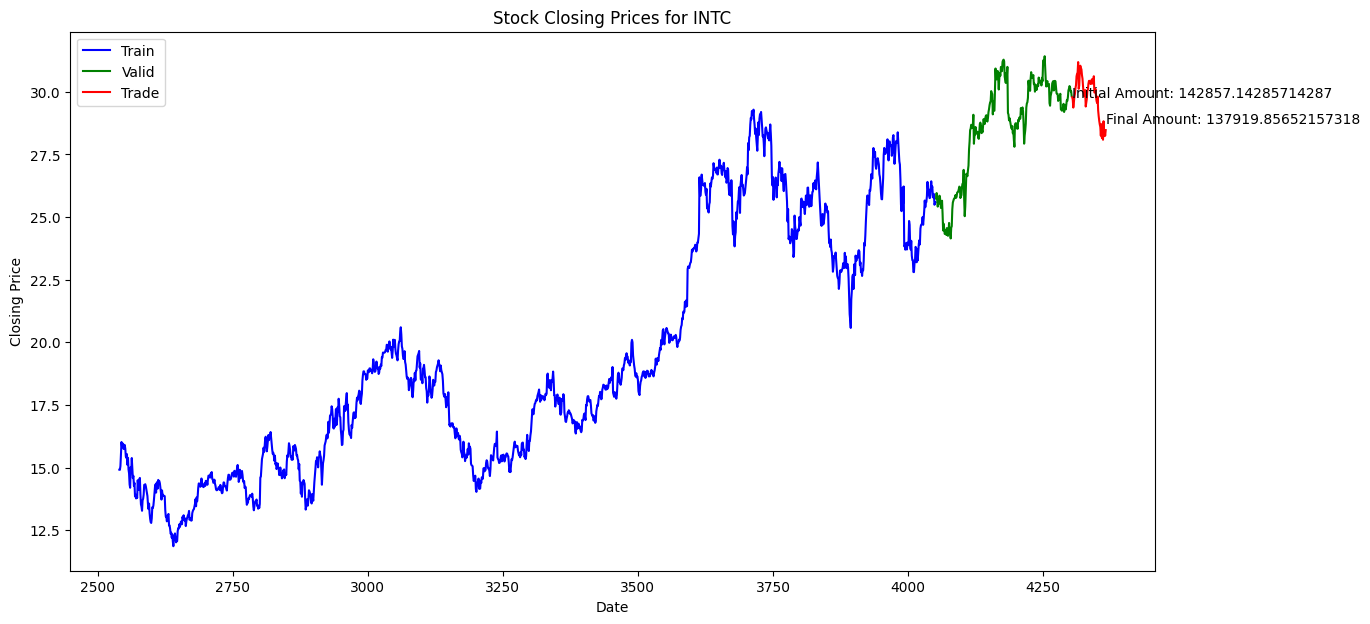

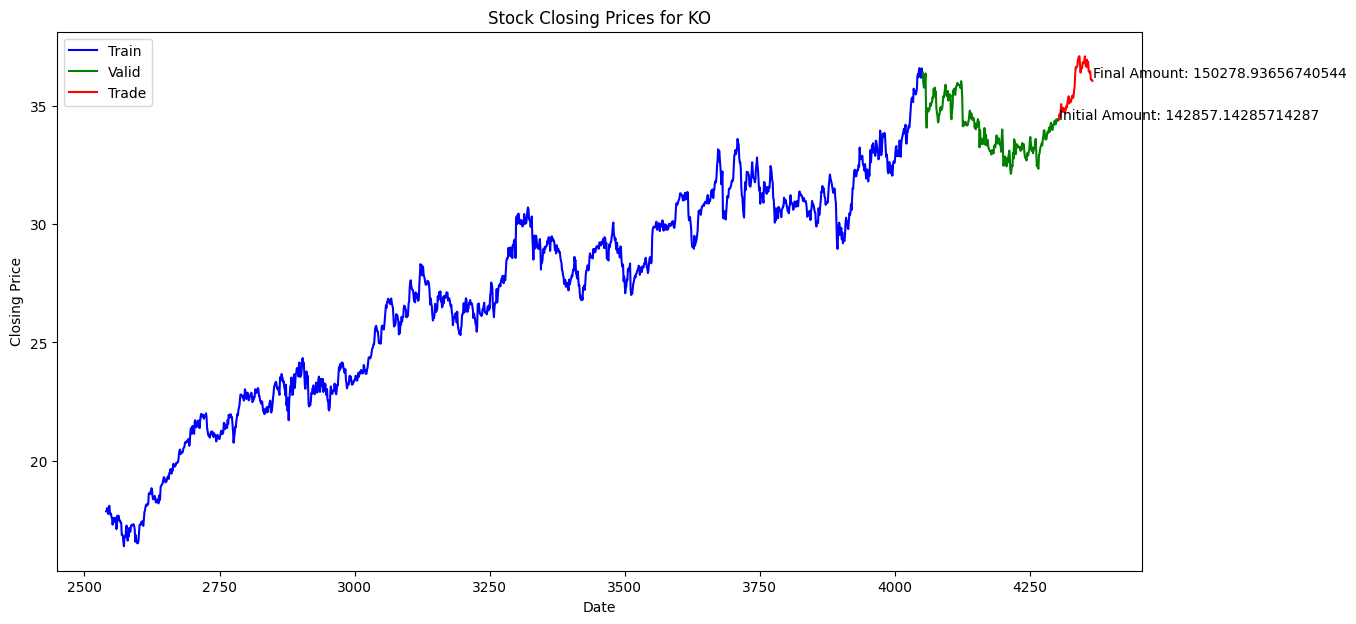

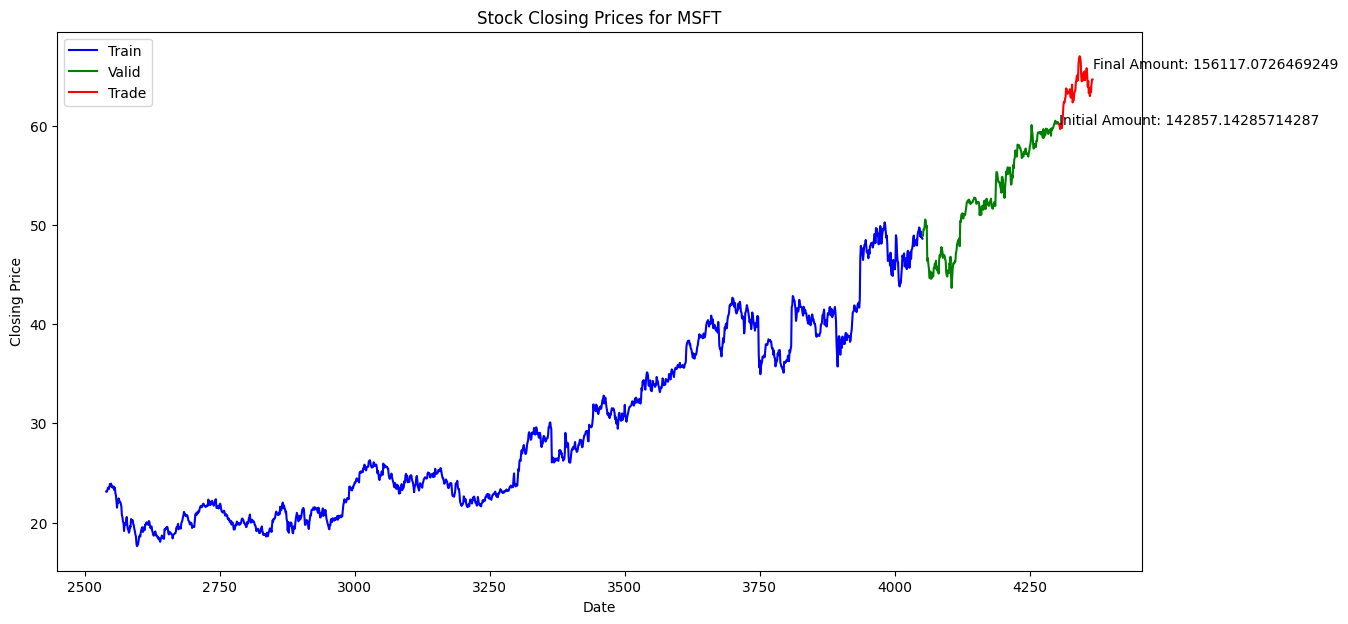

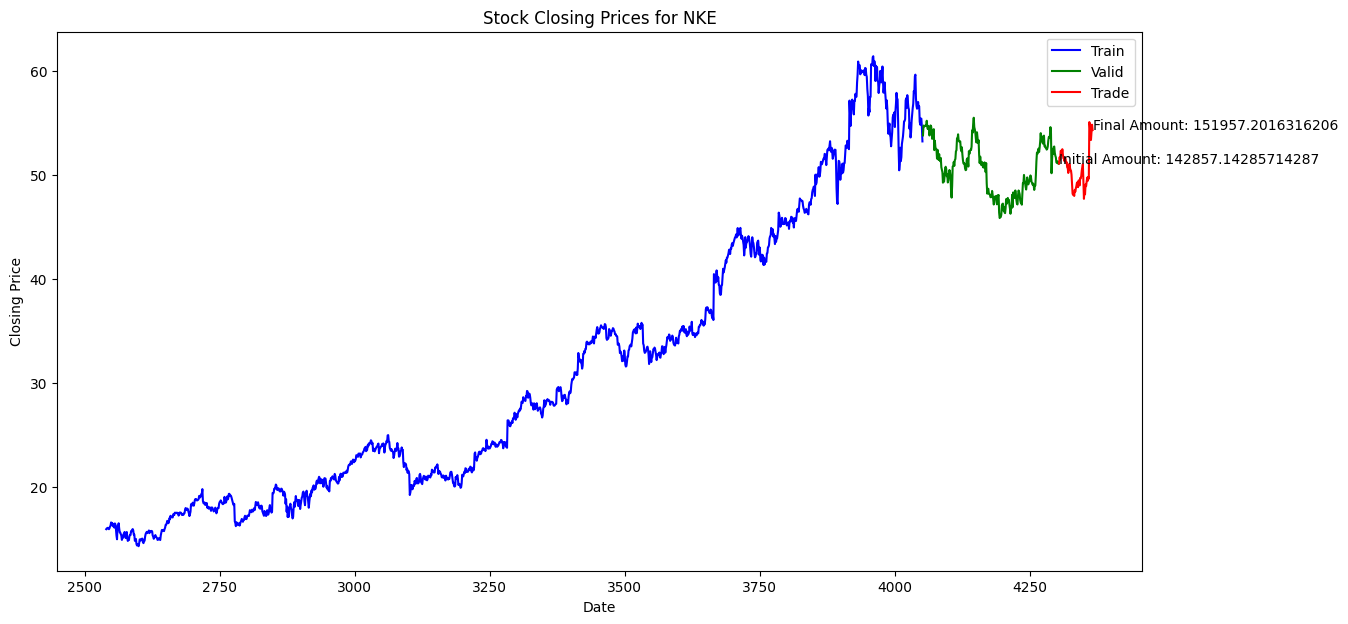

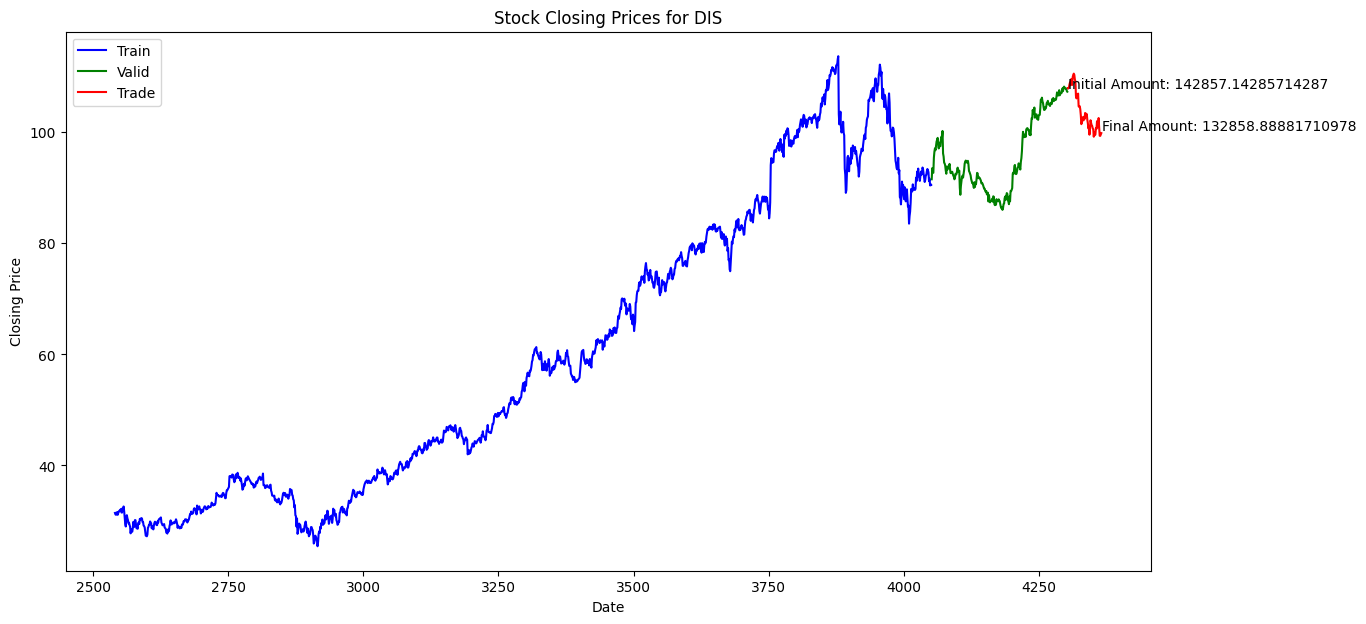

[I 2024-03-12 09:47:35,826] A new study created in memory with name: A2C_study


cycle
0
train indexes
17780 28364
validation indexes
28364 30128
lenght of the datasets:
10584 1764
min and max train date
2010-04-09 2016-04-11
min and max validation date
2016-04-12 2017-04-10
train dataset.shape
(10584, 13)
validation dataset.shape
(1764, 13)
 - insample_turbulence_threshold: - 
1.7663442213946396
 - historical_turbulence_mean: - 
0.8687405171256483
 - Turbulence_threshold: - 
6.4226045282797015

******************* reset initial TRAIN *******************
asset memory reset initial [1000000]
init_obs reset executed

 - Optuna train from:  2010-04-09 to  2017-04-10

******************* reset initial TRAIN *******************
asset memory reset initial [1000000]


C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


TRAIN STEP TERMINAL A2C_selected_timesteps55000 over steps: 0 1763
TRAIN initial asset 1000000
TRAIN end_total_asset 1592018.2393091335
TRAIN total_reward 592018.2393091335 == 592018.2393091335
TRAIN total_cost:  340134.0794207979
TRAIN total trades:  11679
TRAIN Sharpe Ratio:  0.5213939470049024 ,


******************* reset NOT initial TRAIN *******************
TRAIN STEP TERMINAL A2C_selected_timesteps55000 over steps: 1763 3526
TRAIN initial asset 1000000
TRAIN end_total_asset 1612023.6737151977
TRAIN total_reward 612023.6737151977 == 612023.6737151977
TRAIN total_cost:  638072.3960623337
TRAIN total trades:  23355
TRAIN Sharpe Ratio:  0.5359106191115495 ,


******************* reset NOT initial TRAIN *******************
TRAIN STEP TERMINAL A2C_selected_timesteps55000 over steps: 3526 5289
TRAIN initial asset 1000000
TRAIN end_total_asset 1869534.526973078
TRAIN total_reward 869534.526973078 == 869534.526973078
TRAIN total_cost:  958549.9696545504
TRAIN total trades:  34931
TRAIN S

[I 2024-03-12 09:48:59,510] Trial 0 finished with value: 0.8198010480668038 and parameters: {'learning_rate': 0.00017670169402947956, 'gamma': 0.9900477898513422, 'gae_lambda': 0.9463987883622811, 'n_steps': 1199, 'ent_coef': 0.07800932022121826, 'vf_coef': 0.07799726016810132}. Best is trial 0 with value: 0.8198010480668038.
C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



optim_hyperparams {'learning_rate': 0.00017670169402947956, 'gamma': 0.9900477898513422, 'gae_lambda': 0.9463987883622811, 'n_steps': 1199, 'ent_coef': 0.07800932022121826, 'vf_coef': 0.07799726016810132}

******************* reset initial TRAIN *******************
asset memory reset initial [1000000]
init_obs reset executed

 - Model retrain from:  2010-04-09 to  2017-04-10

******************* reset initial TRAIN *******************
asset memory reset initial [1000000]
TRAIN STEP TERMINAL A2C_selected_timesteps55000 over steps: 0 1763
TRAIN initial asset 1000000
TRAIN end_total_asset 1669307.5168200638
TRAIN total_reward 669307.5168200638 == 669307.5168200638
TRAIN total_cost:  310479.6624789537
TRAIN total trades:  11491
TRAIN Sharpe Ratio:  0.5674810055950031 ,


******************* reset NOT initial TRAIN *******************
TRAIN STEP TERMINAL A2C_selected_timesteps55000 over steps: 1763 3526
TRAIN initial asset 1000000
TRAIN end_total_asset 1964105.2209746453
TRAIN total_reward

C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



self.day 4363
hmax: 1020.7328806777657

initial actions [ 0.11292668 -0.17362568 -0.5548921  -0.01991911 -0.09249021 -1.
 -0.42343566]
final actions [  115.267975  -177.22545   -566.39667    -20.332094   -94.4078
 -1020.7329    -432.21472 ]
--------------------------   SELL    ---------------------------
asset (increment) after sell: 54780.141383441565
=
self.state[index+1] 53.7211799621582
*
min(abs(action),self.state[index+self.stocks_dim+1]) 1020.7329
*
(1- self.transaction_cost_pct) 0.999

asset (without stock return) after sell: 54799.12147981042
------------------------------------------------------------------
--------------------------   SELL    ---------------------------
asset (increment) after sell: 43534.39747308536
=
self.state[index+1] 100.8248291015625
*
min(abs(action),self.state[index+self.stocks_dim+1]) 432.21472
*
(1- self.transaction_cost_pct) 0.999

asset (without stock return) after sell: 98333.51895289577
---------------------------------------------------------

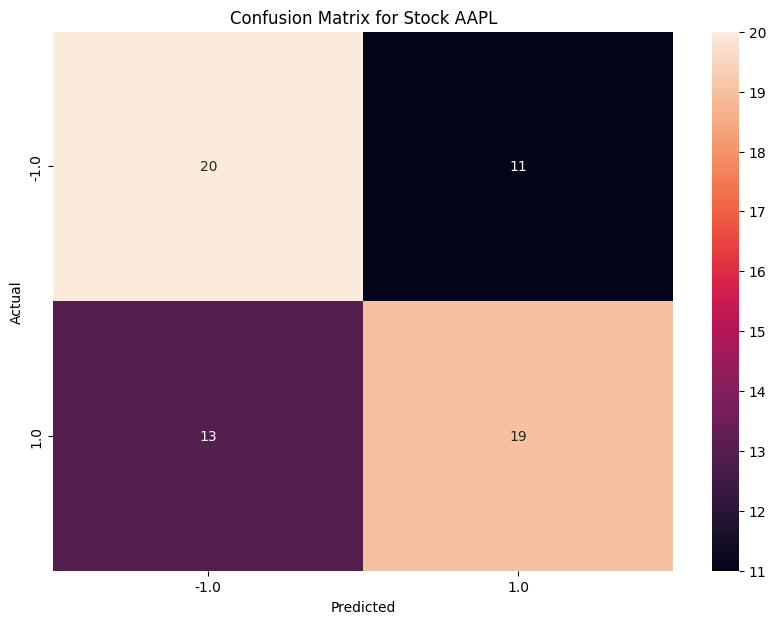


Pred VS Actual values for Stock BA:
[(4304, ('Pred:', -1000.0, '-->', -1.0), ('Act:', 166.98411560058594, 166.0396270751953, '-->', 1.0)), (4305, ('Pred:', 834.316, '-->', 1.0), ('Act:', 164.6276092529297, 166.98411560058594, '-->', -1.0)), (4306, ('Pred:', -997.95593, '-->', -1.0), ('Act:', 164.22549438476562, 164.6276092529297, '-->', -1.0)), (4307, ('Pred:', -848.7906, '-->', -1.0), ('Act:', 167.40489196777344, 164.22549438476562, '-->', 1.0)), (4308, ('Pred:', -107.41119, '-->', -1.0), ('Act:', 166.31082153320312, 167.40489196777344, '-->', -1.0)), (4309, ('Pred:', 79.79854, '-->', 1.0), ('Act:', 166.8251495361328, 166.31082153320312, '-->', 1.0)), (4310, ('Pred:', 139.13524, '-->', 1.0), ('Act:', 167.66673278808594, 166.8251495361328, '-->', 1.0)), (4311, ('Pred:', 176.86595, '-->', 1.0), ('Act:', 168.67666625976562, 167.66673278808594, '-->', 1.0)), (4312, ('Pred:', 1003.59534, '-->', 1.0), ('Act:', 170.24765014648438, 168.67666625976562, '-->', 1.0)), (4313, ('Pred:', -211.3189

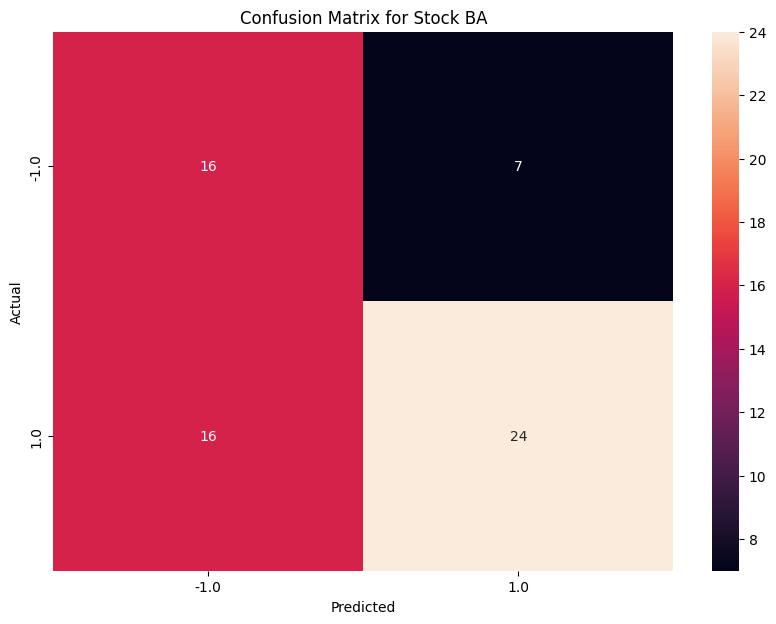


Pred VS Actual values for Stock INTC:
[(4304, ('Pred:', -248.4324, '-->', -1.0), ('Act:', 29.7795467376709, 29.82953453063965, '-->', -1.0)), (4305, ('Pred:', -75.49013, '-->', -1.0), ('Act:', 29.687883377075195, 29.7795467376709, '-->', -1.0)), (4306, ('Pred:', 997.95593, '-->', 1.0), ('Act:', 29.37126350402832, 29.687883377075195, '-->', -1.0)), (4307, ('Pred:', 693.41516, '-->', 1.0), ('Act:', 29.56290054321289, 29.37126350402832, '-->', 1.0)), (4308, ('Pred:', 998.8943, '-->', 1.0), ('Act:', 29.804536819458008, 29.56290054321289, '-->', 1.0)), (4309, ('Pred:', -266.76086, '-->', -1.0), ('Act:', 29.921199798583984, 29.804536819458008, '-->', 1.0)), (4310, ('Pred:', 97.601974, '-->', 1.0), ('Act:', 30.14616203308105, 29.921199798583984, '-->', 1.0)), (4311, ('Pred:', -1001.3258, '-->', -1.0), ('Act:', 30.26280975341797, 30.14616203308105, '-->', 1.0)), (4312, ('Pred:', -886.38727, '-->', -1.0), ('Act:', 30.6211051940918, 30.26280975341797, '-->', 1.0)), (4313, ('Pred:', -892.30347, 

C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


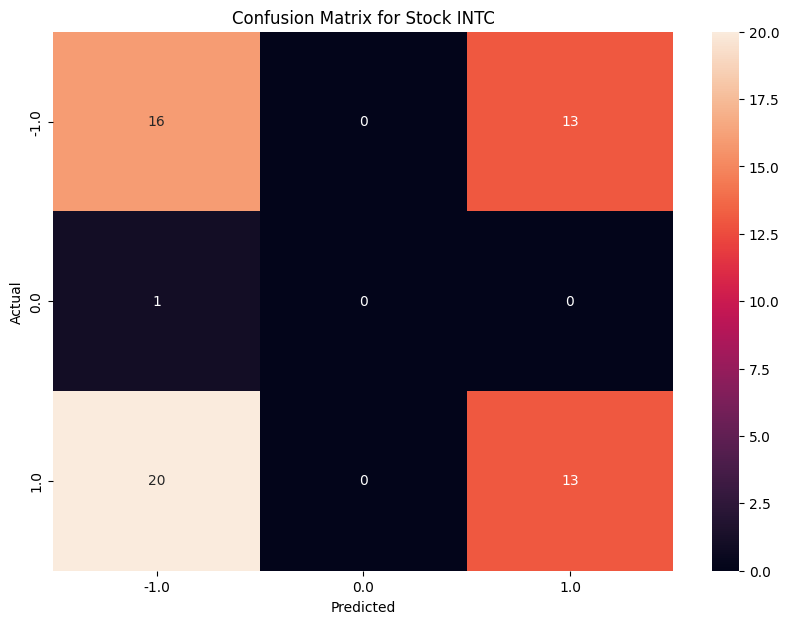


Pred VS Actual values for Stock KO:
[(4304, ('Pred:', -200.7367, '-->', -1.0), ('Act:', 34.428096771240234, 34.45230484008789, '-->', -1.0)), (4305, ('Pred:', -999.89124, '-->', -1.0), ('Act:', 34.65407180786133, 34.428096771240234, '-->', 1.0)), (4306, ('Pred:', -114.610985, '-->', -1.0), ('Act:', 34.53302001953125, 34.65407180786133, '-->', -1.0)), (4307, ('Pred:', 997.1775, '-->', 1.0), ('Act:', 34.758995056152344, 34.53302001953125, '-->', 1.0)), (4308, ('Pred:', 266.81793, '-->', 1.0), ('Act:', 35.089874267578125, 34.758995056152344, '-->', 1.0)), (4309, ('Pred:', -854.7037, '-->', -1.0), ('Act:', 34.88810729980469, 35.089874267578125, '-->', -1.0)), (4310, ('Pred:', -128.31075, '-->', -1.0), ('Act:', 34.77511215209961, 34.88810729980469, '-->', -1.0)), (4311, ('Pred:', -518.19495, '-->', -1.0), ('Act:', 34.758995056152344, 34.77511215209961, '-->', -1.0)), (4312, ('Pred:', 462.74475, '-->', 1.0), ('Act:', 34.92845916748047, 34.758995056152344, '-->', 1.0)), (4313, ('Pred:', -100

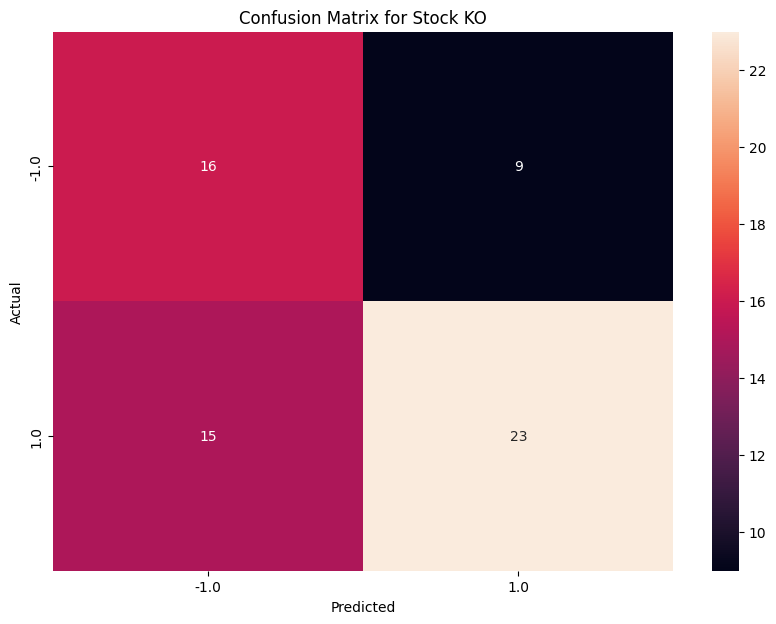


Pred VS Actual values for Stock MSFT:
[(4304, ('Pred:', 795.36, '-->', 1.0), ('Act:', 60.1490364074707, 60.19496154785156, '-->', -1.0)), (4305, ('Pred:', 888.9158, '-->', 1.0), ('Act:', 59.91938400268555, 60.1490364074707, '-->', -1.0)), (4306, ('Pred:', -997.95593, '-->', -1.0), ('Act:', 59.66217422485352, 59.91938400268555, '-->', -1.0)), (4307, ('Pred:', -135.54994, '-->', -1.0), ('Act:', 60.1490364074707, 59.66217422485352, '-->', 1.0)), (4308, ('Pred:', 998.8943, '-->', 1.0), ('Act:', 60.066349029541016, 60.1490364074707, '-->', -1.0)), (4309, ('Pred:', 212.32895, '-->', 1.0), ('Act:', 59.74485778808594, 60.066349029541016, '-->', -1.0)), (4310, ('Pred:', 998.5227, '-->', 1.0), ('Act:', 60.16740417480469, 59.74485778808594, '-->', 1.0)), (4311, ('Pred:', -468.0952, '-->', -1.0), ('Act:', 60.99413299560547, 60.16740417480469, '-->', 1.0)), (4312, ('Pred:', 1003.59534, '-->', 1.0), ('Act:', 62.03212356567383, 60.99413299560547, '-->', 1.0)), (4313, ('Pred:', 1009.8036, '-->', 1.0)

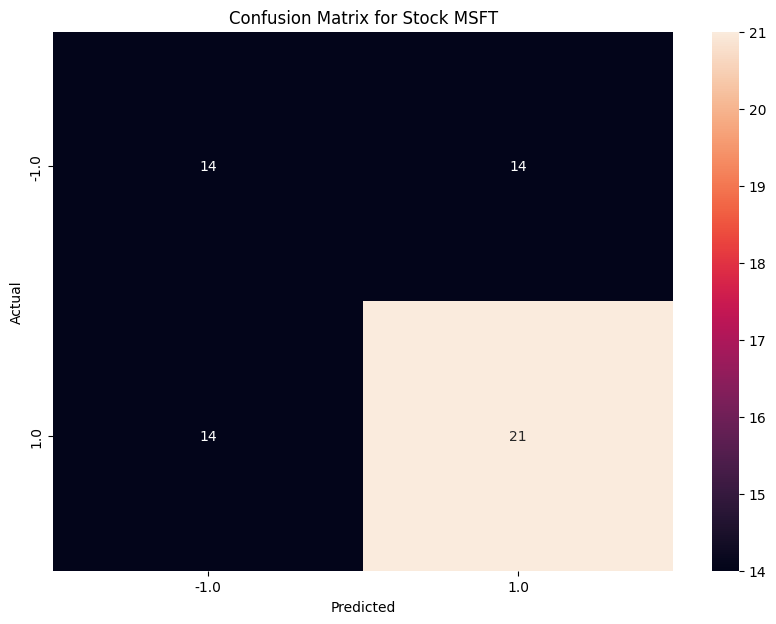


Pred VS Actual values for Stock NKE:
[(4304, ('Pred:', 750.54224, '-->', 1.0), ('Act:', 51.08313751220703, 51.06452941894531, '-->', 1.0)), (4305, ('Pred:', 282.913, '-->', 1.0), ('Act:', 51.68772506713867, 51.08313751220703, '-->', 1.0)), (4306, ('Pred:', -997.95593, '-->', -1.0), ('Act:', 51.47378540039063, 51.68772506713867, '-->', -1.0)), (4307, ('Pred:', 997.1775, '-->', 1.0), ('Act:', 52.3109245300293, 51.47378540039063, '-->', 1.0)), (4308, ('Pred:', 265.95264, '-->', 1.0), ('Act:', 52.18999481201172, 52.3109245300293, '-->', -1.0)), (4309, ('Pred:', -444.3273, '-->', -1.0), ('Act:', 51.95746994018555, 52.18999481201172, '-->', -1.0)), (4310, ('Pred:', -508.5363, '-->', -1.0), ('Act:', 52.45974349975586, 51.95746994018555, '-->', 1.0)), (4311, ('Pred:', -1001.3258, '-->', -1.0), ('Act:', 51.94815826416016, 52.45974349975586, '-->', -1.0)), (4312, ('Pred:', -1003.59534, '-->', -1.0), ('Act:', 51.594722747802734, 51.94815826416016, '-->', -1.0)), (4313, ('Pred:', -40.535168, '-->

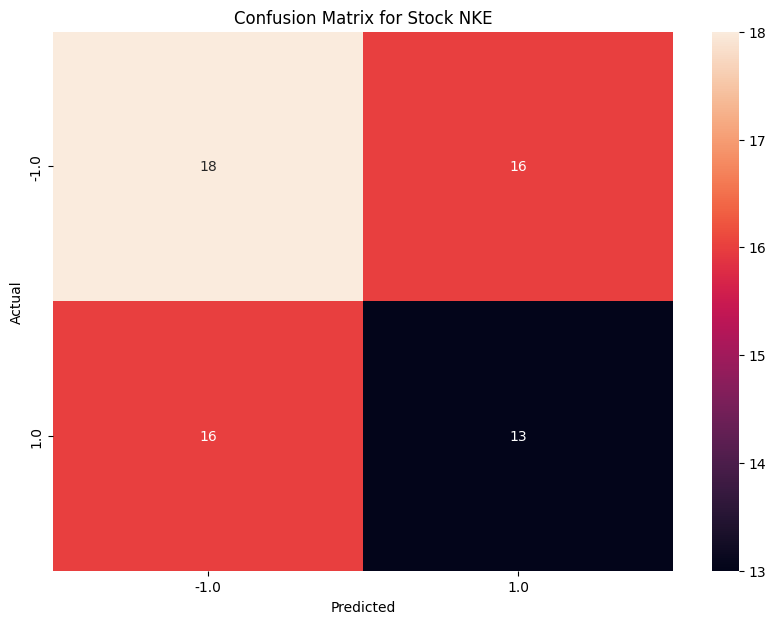


Pred VS Actual values for Stock DIS:
[(4304, ('Pred:', -231.14185, '-->', -1.0), ('Act:', 107.92638397216795, 107.31549835205078, '-->', 1.0)), (4305, ('Pred:', -696.42773, '-->', -1.0), ('Act:', 107.89774322509766, 107.92638397216795, '-->', -1.0)), (4306, ('Pred:', -333.02847, '-->', -1.0), ('Act:', 108.05046844482422, 107.89774322509766, '-->', 1.0)), (4307, ('Pred:', -166.50786, '-->', -1.0), ('Act:', 108.60407257080078, 108.05046844482422, '-->', 1.0)), (4308, ('Pred:', -741.9634, '-->', -1.0), ('Act:', 108.99542999267578, 108.60407257080078, '-->', 1.0)), (4309, ('Pred:', 199.05338, '-->', 1.0), ('Act:', 108.5563507080078, 108.99542999267578, '-->', -1.0)), (4310, ('Pred:', 97.32952, '-->', 1.0), ('Act:', 109.56813049316406, 108.5563507080078, '-->', 1.0)), (4311, ('Pred:', -551.45154, '-->', -1.0), ('Act:', 109.23406219482422, 109.56813049316406, '-->', -1.0)), (4312, ('Pred:', -877.2602, '-->', -1.0), ('Act:', 108.52772521972656, 109.23406219482422, '-->', -1.0)), (4313, ('Pre

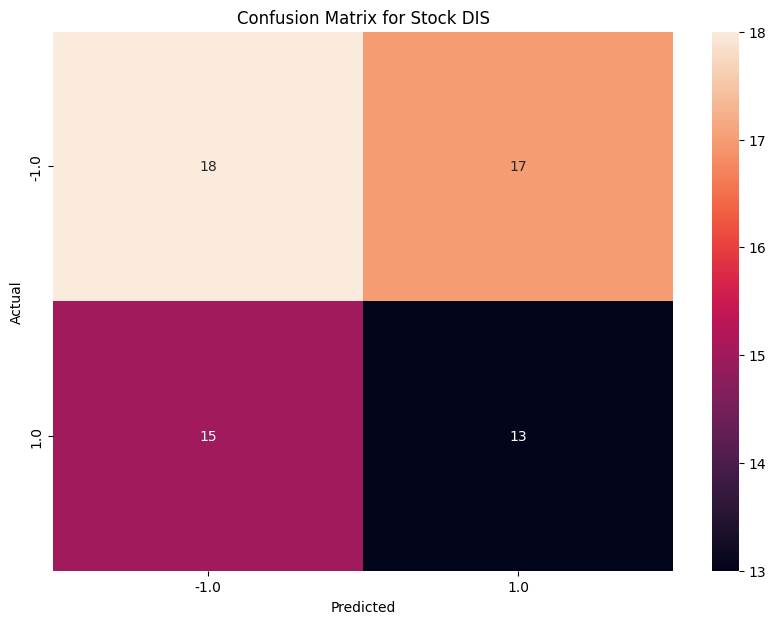


curr_obs_last_s
 [ 1.00000000e+06  3.34546547e+01  1.66039627e+02  2.98295345e+01
  3.44523048e+01  6.01949615e+01  5.10645294e+01  1.07315498e+02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.01923245e-01
  3.60803962e+00 -4.31334764e-01 -4.60099466e-02 -8.41266960e-02
  1.29207587e+00 -6.56892002e-01  4.79834747e+01  7.23858643e+01
  4.22956276e+01  4.68622398e+01  5.27433243e+01  6.21226921e+01
  4.30952835e+01  3.38220825e+01  1.59775635e+02 -7.04671173e+01
 -1.63290237e+02  4.44344292e+01  1.08646576e+02 -9.09385605e+01
  2.51958346e+00  1.30584116e+01  5.85166883e+00  8.62669373e+00
  5.83910370e+00  4.24937868e+00  5.32854271e+00  2.13035069e+01
  2.61206512e+01  2.43180447e+01  2.08309689e+01  1.67735081e+01
  2.14281540e+01  3.19037762e+01]

predicted validation actions (last day)
 [[-0.03537537 -0.29609966 -0.07764266 -0.09401722  1.         -1.
   0.47682923]]
Whole Strategy took:  2.8731454292933147  mi

In [12]:
run_strategy( df=df, 
              date_start=config_.date_start,
              train_init_quarters=config_.train_init_quarters, 
              valid_quarters=config_.valid_quarters, 
              trade_quarters=config_.trade_quarters, 
              max_rebalances_input=config_.max_rebalances_input, 
              rebalance_quarters=config_.rebalance_quarters)

In [13]:
stringa = """
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[12], line 1
----> 1 run_strategy( df=df, 
      2               date_start=config_.date_start,
      3               train_init_quarters=config_.train_init_quarters, 
      4               valid_quarters=config_.valid_quarters, 
      5               trade_quarters=config_.trade_quarters, 
      6               max_rebalances_input=config_.max_rebalances_input, 
      7               rebalance_quarters=config_.rebalance_quarters)

Cell In[11], line 251, in run_strategy(df, date_start, train_init_quarters, valid_quarters, trade_quarters, rebalance_quarters, max_rebalances_input)
    247 # logging_callback = LoggingCallback(threshold=1e-5,patience=30,trial_number=5)
    249 study = optuna.create_study(study_name="A2C_study",direction='maximize', sampler = sampler, pruner=optuna.pruners.HyperbandPruner())
--> 251 study.optimize(objective, n_trials=30)
    252 # study.optimize(lambda trial: objective(env_retrain, trial), n_trials=30)
    253 # study.optimize(objective, n_trials=30,catch=(ValueError, TypeError),callbacks=[logging_callback])
    254 
    255 #add the new optimal hyperparameters in the last training
    256 model_selected = train_A2C(env_retrain, model_name=model_name, timesteps=config_.A2C_TS, working_path=working_path)

File ~\miniconda3\envs\py309\lib\site-packages\optuna\study\study.py:451, in Study.optimize(self, func, n_trials, timeout, n_jobs, catch, callbacks, gc_after_trial, show_progress_bar)
    348 def optimize(
    349     self,
    350     func: ObjectiveFuncType,
   (...)
    357     show_progress_bar: bool = False,
    358 ) -> None:
    359     Optimize an objective function.
    360 
    361     Optimization is done by choosing a suitable set of hyperparameter values from a given
   (...)
    449             If nested invocation of this method occurs.
    450     
--> 451     _optimize(
    452         study=self,
    453         func=func,
    454         n_trials=n_trials,
    455         timeout=timeout,
    456         n_jobs=n_jobs,
    457         catch=tuple(catch) if isinstance(catch, Iterable) else (catch,),
    458         callbacks=callbacks,
    459         gc_after_trial=gc_after_trial,
    460         show_progress_bar=show_progress_bar,
    461     )

File ~\miniconda3\envs\py309\lib\site-packages\optuna\study\_optimize.py:66, in _optimize(study, func, n_trials, timeout, n_jobs, catch, callbacks, gc_after_trial, show_progress_bar)
     64 try:
     65     if n_jobs == 1:
---> 66         _optimize_sequential(
     67             study,
     68             func,
     69             n_trials,
     70             timeout,
     71             catch,
     72             callbacks,
     73             gc_after_trial,
     74             reseed_sampler_rng=False,
     75             time_start=None,
     76             progress_bar=progress_bar,
     77         )
     78     else:
     79         if n_jobs == -1:

File ~\miniconda3\envs\py309\lib\site-packages\optuna\study\_optimize.py:163, in _optimize_sequential(study, func, n_trials, timeout, catch, callbacks, gc_after_trial, reseed_sampler_rng, time_start, progress_bar)
    160         break
    162 try:
--> 163     frozen_trial = _run_trial(study, func, catch)
    164 finally:
    165     # The following line mitigates memory problems that can be occurred in some
    166     # environments (e.g., services that use computing containers such as GitHub Actions).
    167     # Please refer to the following PR for further details:
    168     # https://github.com/optuna/optuna/pull/325.
    169     if gc_after_trial:

File ~\miniconda3\envs\py309\lib\site-packages\optuna\study\_optimize.py:251, in _run_trial(study, func, catch)
    244         assert False, "Should not reach."
    246 if (
    247     frozen_trial.state == TrialState.FAIL
    248     and func_err is not None
    249     and not isinstance(func_err, catch)
    250 ):
--> 251     raise func_err
    252 return frozen_trial

File ~\miniconda3\envs\py309\lib\site-packages\optuna\study\_optimize.py:200, in _run_trial(study, func, catch)
    198 with get_heartbeat_thread(trial._trial_id, study._storage):
    199     try:
--> 200         value_or_values = func(trial)
    201     except exceptions.TrialPruned as e:
    202         # TODO(mamu): Handle multi-objective cases.
    203         state = TrialState.PRUNED

TypeError: objective() missing 1 required positional argument: 'trial'
"""

In [14]:
import re
text = re.sub('\n+', ' ', stringa)
text = re.sub('\\\\+', '/', text)  
text = re.sub('--+', '-', text) 
text = re.sub(' +', '', text)
text

'-TypeErrorTraceback(mostrecentcalllast)CellIn[12],line1->1run_strategy(df=df,2date_start=config_.date_start,3train_init_quarters=config_.train_init_quarters,4valid_quarters=config_.valid_quarters,5trade_quarters=config_.trade_quarters,6max_rebalances_input=config_.max_rebalances_input,7rebalance_quarters=config_.rebalance_quarters)CellIn[11],line251,inrun_strategy(df,date_start,train_init_quarters,valid_quarters,trade_quarters,rebalance_quarters,max_rebalances_input)247#logging_callback=LoggingCallback(threshold=1e-5,patience=30,trial_number=5)249study=optuna.create_study(study_name="A2C_study",direction=\'maximize\',sampler=sampler,pruner=optuna.pruners.HyperbandPruner())->251study.optimize(objective,n_trials=30)252#study.optimize(lambdatrial:objective(env_retrain,trial),n_trials=30)253#study.optimize(objective,n_trials=30,catch=(ValueError,TypeError),callbacks=[logging_callback])254255#addthenewoptimalhyperparametersinthelasttraining256model_selected=train_A2C(env_retrain,model_name

In [15]:
len(text)

3319